# Task 6 - BERT fine-tuning for classification
Team Members

*   Libin Kutty
*   Viju Sudhi
*   Ritu Gahir

In [1]:
%tensorflow_version 2.x

In [2]:
pip install -q tf-nightly

     |████████████████████████████████| 390.2MB 40kB/s 
     |████████████████████████████████| 460kB 44.6MB/s 
     |████████████████████████████████| 10.1MB 40.8MB/s 


In [3]:
pip install -q tf-models-nightly

     |████████████████████████████████| 1.0MB 2.8MB/s 
     |████████████████████████████████| 276kB 11.6MB/s 
     |████████████████████████████████| 102kB 8.1MB/s 
     |████████████████████████████████| 174kB 16.8MB/s 
     |████████████████████████████████| 1.1MB 16.1MB/s 
     |████████████████████████████████| 358kB 26.5MB/s 
     |████████████████████████████████| 36.6MB 118kB/s 


In [4]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [5]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [6]:
glue, info = tfds.load('glue/cola', with_info=True,
                       batch_size=-1)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/glue/cola/1.0.0.incomplete53ZZCM/glue-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/glue/cola/1.0.0.incomplete53ZZCM/glue-validation.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/glue/cola/1.0.0.incomplete53ZZCM/glue-test.tfrecord
Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/cola/1.0.0. Subsequent calls will reuse this data.


In [7]:
list(glue.keys())

['test', 'train', 'validation']

In [8]:
info.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence': Text(shape=(), dtype=tf.string),
})

In [9]:
info.features['label'].names

['unacceptable', 'acceptable']

In [10]:
glue_train = glue['train']

for key, value in glue_train.items():
  print(f"{key:9s}: {value[0].numpy()}")

idx      : 1680
label    : 1
sentence : b'It is this hat that it is certain that he was wearing.'


In [11]:
glue_train.items()

dict_items([('idx', <tf.Tensor: shape=(8551,), dtype=int32, numpy=array([1680, 1456, 4223, ..., 3624, 8351, 5073], dtype=int32)>), ('label', <tf.Tensor: shape=(8551,), dtype=int64, numpy=array([1, 1, 1, ..., 1, 0, 1])>), ('sentence', <tf.Tensor: shape=(8551,), dtype=string, numpy=
array([b'It is this hat that it is certain that he was wearing.',
       b'Her efficient looking up of the answer pleased the boss.',
       b'Both the workers will wear carnations.', ...,
       b'John looked up the inside of the chimney.',
       b'You said she liked yourself',
       b"What we're using is their teaching material."], dtype=object)>)])

In [12]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [13]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


In [14]:
tokenizer.convert_tokens_to_ids(['[CLS]'])

[101]

In [15]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s.numpy()))
   return tokenizer.convert_tokens_to_ids(tokens)

sentence = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence"]])

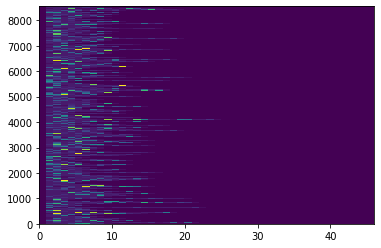

In [16]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence.shape[0]
input_word_ids = tf.concat([cls, sentence], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

In [17]:
print("Sentence shape:", sentence.shape.as_list())

Sentence shape: [8551, None]


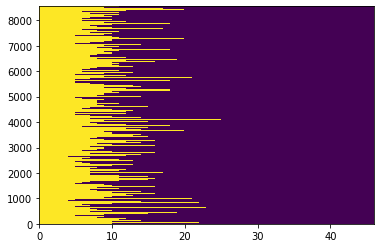

In [18]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

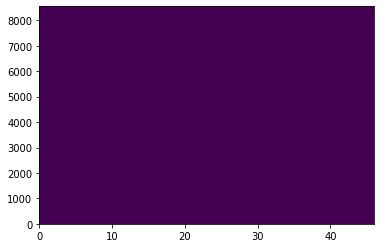

In [19]:
type_cls = tf.zeros_like(cls)
type_s = tf.zeros_like(sentence)
input_type_ids = tf.concat([type_cls, type_s], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

In [20]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
  num_examples = len(glue_dict["sentence"])
  
  sentence = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(glue_dict["sentence"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence.shape[0]
  input_word_ids = tf.concat([cls, sentence], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s = tf.zeros_like(sentence)
  input_type_ids = tf.concat(
      [type_cls, type_s], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [21]:
glue_train = bert_encode(glue['train'], tokenizer)
glue_train_labels = glue['train']['label']

glue_validation = bert_encode(glue['validation'], tokenizer)
glue_validation_labels = glue['validation']['label']

glue_test = bert_encode(glue['test'], tokenizer)
glue_test_labels  = glue['test']['label']

In [22]:
for key, value in glue_train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'glue_train_labels shape: {glue_train_labels.shape}')

input_word_ids  shape: (8551, 46)
input_mask      shape: (8551, 46)
input_type_ids  shape: (8551, 46)
glue_train_labels shape: (8551,)


In [23]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [24]:
_, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

In [25]:
bert_encoder.input

[<KerasTensor: shape=(None, None) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, None) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, None) dtype=int32 (created by layer 'input_type_ids')>]

In [26]:
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

In [34]:
manual_classifier = nlp.modeling.models.BertClassifier(
        bert_encoder,
        num_classes=2,
        dropout_rate=0.2,
        initializer=tf.keras.initializers.TruncatedNormal(
          stddev=bert_config.initializer_range))

In [35]:
# Set up epochs and steps
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [36]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

manual_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

manual_classifier.fit(
      glue_train, glue_train_labels,
      validation_data=(glue_validation, glue_validation_labels),
      batch_size=32,
      epochs=epochs)

Epoch 1/3
268/268 [==============================] - 4184s 16s/step - loss: 0.6033 - accuracy: 0.6782 - val_loss: 0.4918 - val_accuracy: 0.7603
Epoch 2/3
268/268 [==============================] - 4136s 15s/step - loss: 0.4103 - accuracy: 0.8175 - val_loss: 0.4762 - val_accuracy: 0.7824
Epoch 3/3
268/268 [==============================] - 4142s 15s/step - loss: 0.2965 - accuracy: 0.8834 - val_loss: 0.5309 - val_accuracy: 0.7987


In [27]:
my_examples = bert_encode(
    glue_dict = {
        'sentence':[
            'The rain in Spain falls mainly on the plain.',
            'Look I fine tuned BERT.']
    },
    tokenizer=tokenizer)

In [40]:
result = manual_classifier(my_examples, training=False)

result = tf.argmax(result).numpy()
result

array([1, 0])

In [29]:
result = bert_encoder(my_examples, training=True)

print("Sequence output shape:", result[0].shape)
print("Pooled output shape:", result[1].shape)

Sequence output shape: (2, 1, 768)
Pooled output shape: (2, 768)


I couldn't figure out how to add layers manually as it was giving me error that's why I have done it this way.

# Conclusion

---
  * What is the tutorial classifying when using the GLUE MRPC data set? - Classifying whether the two sentence are equivalent to each other
  * In addition to the input itself, the tutorial feeds two binary tensors for input mask and input type to the model. Is this necessary for the data set single sentence classification? - Mask is necessary to handle padded sentences. Input type is not necessary as there is only one sentence
  * How does the tokenization in BERT differ from the one in the previous Task 5? - In bert, you give full sentence as the input to the model, in NMT, you give one word at a time. You add 'SOS' and 'EOS' in NMT to explain start and end of sentence.
  * What is a [CLS] token and what is it used for? - It is used for determining that the sentence is used for classification task. We focus on the output of only the first position (that we passed the special [CLS] token to)
  * Which part of the BERT encoding is used for the classification?
  Does your answer match the output shape of the encoder?
  * Are the BERT encoder weights also fine-tuned to the task? - No, we use the pre trained weights and learn new weights. Transfer Learning. While training with new data, the accuracy starts with 48% which shows Transfer Learning.
